In [6]:
import subprocess
import sys
import os
import argparse
from distutils.version import LooseVersion
import glob
from pathlib import Path
import json
import time
import bilby
import nmma

import astropy
import numpy as np
import pandas as pd

from astropy.time import Time

import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')
warnings.simplefilter("ignore", UserWarning)

In [7]:
from nmma.em.model import SimpleKilonovaLightCurveModel,GRBLightCurveModel, SVDLightCurveModel, KilonovaGRBLightCurveModel, GenericCombineLightCurveModel, SupernovaLightCurveModel, ShockCoolingLightCurveModel

from nmma.em.injection import create_light_curve_data as cld

snModel = lambda t: SupernovaLightCurveModel(sample_times=t, model='nugent-hyper')
grbModel = lambda t: GRBLightCurveModel(sample_times=t, model='TrPi2018')
knModel = lambda t: SVDLightCurveModel(sample_times=t, model='Bu2019lm')

In [8]:

modelDict = lambda t: {'nugent-hyper':snModel(t), 'TrPi2018':grbModel(t), 'Bu2019lm':knModel(t)}
print(modelDict([1])['nugent-hyper'])

SupernovaLightCurveModel(model={self.model})


In [9]:
# modelDict([1])['Bu2019lm'].generate_lightcurve(sample_times=np.array([1]), parameters=best_params)

In [10]:
def luminosity(distance, mag):
    """
    Calculate the luminosity of a source given its distance and apparent magnitude.
    Parameters
    """
    abs = lambda mag, distance: mag + 5 * np.log10(distance * 1e6 / 10.0)
    if type(mag) == np.ndarray:
        return abs(mag, distance)
    elif type(mag) == dict:
        return {k: abs(mag[k], distance) for k in mag.keys()} 

def read_json(path_to_file):
    with open(path_to_file) as p:
        return json.load(p, object_hook=bilby.core.utils.decode_bilby_json)

In [11]:
results = glob.glob('./fits/*/*result.json')
print("Found {} results".format(len(results)))
print()

Found 189 results



In [12]:
root_directory = Path('./fits/')
total_size = sum(f.stat().st_size for f in root_directory.glob('**/*') if f.is_file()) / 1024**3
print("Total size: {:.2f} GB".format(total_size))
json_size = sum(f.stat().st_size for f in root_directory.glob('**/*result.json') if f.is_file()) / 1024**3
print("JSON size: {:.2f} GB".format(json_size))
print('json files occupy {:.2f}% of the total size'.format(json_size / total_size * 100))

Total size: 2.32 GB
JSON size: 0.75 GB
json files occupy 32.42% of the total size


In [13]:
start = time.time()
jsons = [read_json(f) for f in results]
stop = time.time()
print("Reading {} json files took {:.2f} seconds \n(average {:.2f} sec/file)".format(len(jsons), stop - start, (stop - start) / len(jsons)))

Reading 189 json files took 12.09 seconds 
(average 0.06 sec/file)


In [14]:
jsons[0]['label'].split('_')[0] + '_' + jsons[0]['label'].split('_')[1] + '_' + jsons[0]['label'].split('_')[-2] + '_' + jsons[0]['label'].split('_')[-1]
jsons[0]['label'].split('_')[3] 

'Bu2019lm'

In [15]:
posterior_samples = [j['posterior'] for j in jsons]

In [16]:
ll_idx = np.argmin(np.abs(jsons[0]['log_likelihood_evaluations']))
print("Best log likelihood evaluation: {}".format(ll_idx))
print(jsons[0]['log_likelihood_evaluations'][ll_idx])
print(jsons[0]['samples'][ll_idx])
best_params = dict(zip(jsons[0]['search_parameter_keys'], jsons[0]['samples'][ll_idx]))
display(best_params)

Best log likelihood evaluation: 7906
-21.183629314906504
[ 9.48264161 49.1045723   0.77937232 -1.93927027 -2.50605828 -1.32867461
  0.16131121]


{'luminosity_distance': 9.482641609762611,
 'KNphi': 49.10457230173926,
 'inclination_EM': 0.7793723226107803,
 'KNtimeshift': -1.9392702697004678,
 'log10_mej_dyn': -2.5060582838342813,
 'log10_mej_wind': -1.3286746136344751,
 'Ebv': 0.16131120572259705}

In [17]:
def get_lc(file, tmax=False,remove_nondetections=False):
    '''imports dat file as a pandas dataframe'''
    df = pd.read_csv(file, sep=' ', header=None, names=['t', 'filter', 'mag', 'mag_unc'])
    
    df['t'] = Time(pd.to_datetime(df['t'])).mjd ## convert to mjd
    df['t'] = df['t'] - df['t'].min() ## set t=0 to first observation
    if tmax:
        df = df[df['t'] < tmax]
    df = df[df['mag_unc'] != np.inf] if remove_nondetections else df
    return df

In [18]:
test_df = get_lc('./injection_sample/lc_nugent-hyper_5.dat')
test_df

,t,filter,mag,mag_unc
0,0.000000,g,20.904972,inf
1,1.990721,g,20.471850,inf
2,3.977475,g,20.973354,0.096463
3,5.957242,g,20.657869,0.201637
4,8.952472,g,20.313280,0.167069
5,11.951724,g,20.056542,0.151009
6,13.964049,g,19.997498,0.060664
7,15.915382,g,19.947926,0.088700


In [19]:
def get_best_params(json_path, verbose=False):
    '''Get the best fit parameters from a bilby json_path file, return as a dictionary'''
    # ll_idx = np.argmin(np.abs(json_path['log_likelihood_evaluations']))
    #best_ll = json_path['log_likelihood_evaluations'][ll_idx]
    post = json_path['posterior']
    ll_idx = np.argmin(np.abs(post['log_likelihood']))
    best_ll = post['log_likelihood'][ll_idx]
    post_keys = list(post.keys())
    print("Best log likelihood evaluation: {}".format(best_ll)) if verbose else None
    log_evidence = json_path['log_evidence']
    log_evidence_err = json_path['log_evidence_err']
    log_bayes_factor = json_path['log_bayes_factor']
    likelihood_dict = dict(zip(['log_likelihood','log_evidence', 'log_evidence_err', 'log_bayes_factor'], [best_ll, log_evidence, log_evidence_err, log_bayes_factor]))
    # print(bp_dict) if verbose else None
    #bp_dict = dict(zip(json_path['search_parameter_keys'], json_path['samples'][ll_idx]))
    # bp_dict = dict(zip(json_path['search_parameter_keys'], json_path['samples'][ll_idx, :]))
    bp_dict = dict(zip(post_keys, [post[k][ll_idx] for k in post_keys]))

    return bp_dict, likelihood_dict

def get_labels(json_path):
    '''get the object label from bilby file, return as a dictionary'''
    raw_label = json_path['label']
    candidate = raw_label.split('_')[0] + '_' + raw_label.split('_')[1]
    model = raw_label.split('_')[3]
    tmax = float(raw_label.split('_')[5])
    keys = ['candidate', 'model', 'tmax']
    label_dict = dict(zip(keys, [candidate, model, tmax]))
    
    return label_dict

In [20]:
def gen_lc(json_path, model, sample_times, verbose=False):
    '''Generate a light curve from a bilby json_path file'''
    bp, like_dict = get_best_params(json_path, verbose=verbose)
    model_type = get_labels(json_path)['model']
    model = modelDict(sample_times)[model_type]
    print(model) if verbose else None
    label = get_labels(json_path)
    print(label) if verbose else None
    print(bp) if verbose else None
    print() if verbose else None
    lc = model.generate_lightcurve(sample_times, parameters=bp)[1]
    lc_abs = luminosity(bp['luminosity_distance'], lc)
    return lc_abs, label

def calc_resids(lc, data):
    '''Calculate residuals between a light curve and data'''
    # assert len(lc) == len(data):
    resids = 0
    for filter in data['filter'].unique():
        t_sample = data[data['filter'] == filter]['t']
        lc_filt = lc[filter] #gen_lc(json_path, modelDict(t_sample)['Bu2019lm'], t_sample)[1]
        data_filt = data[data['filter'] == filter]
        resids += np.sum(np.abs(lc_filt - data_filt['mag']))/ data_filt['mag_unc']/len(lc_filt) ## updated in .py script
    return resids


In [21]:
def create_series(json, residuals=False):
    '''creates a pandas series from a bilby json file (already read in)'''
    label_dict = get_labels(json)
    bp_dict, likelihood_dict = get_best_params(json)
    obj_dict = {**label_dict,  **likelihood_dict, **bp_dict,}
    obj_series = pd.Series(obj_dict)
    
    if residuals:
        # print(bp_dict)
        tmax = label_dict['tmax']
        data = get_lc('./injection_sample/lc_{}.dat'.format(label_dict['candidate']),
                      tmax=tmax) ## should be a function argument
        t_sample = np.array(data['t'])
        # print(type(t_sample))
        model = modelDict(t_sample)[label_dict['model']]
        # print("json file: {}".format(json['label']))
        # print("model: {}".format(model))
        # if model == GRBLightCurveModel(model='TrPi2018', sample_times=t_sample):
        #     print(json['log10_E0'])
        
        bf_lc, _ = gen_lc(json, model, t_sample)
        resids = calc_resids(bf_lc, data)
        obj_series['residuals'] = resids
    return obj_series

def create_df(jsons, residuals=False):
    '''creates a pandas dataframe from a list of bilby json files (already read in)'''
    return pd.DataFrame([create_series(j, residuals) for j in jsons]).sort_values(by=['candidate','model','tmax']).reset_index(drop=True)


In [22]:
# import warnings
# warnings.simplefilter("ignore", UserWarning)
# t0 = time.time()
# df = create_df(jsons, residuals=False)
# t1 = time.time()
# print("Creating dataframe (no residuals) took {:.2f} seconds".format(t1-t0))
# df.to_csv('fit_results.csv', index=False)

# t0 = time.time()
# df = create_df(jsons, residuals=True)
# t1 = time.time()
# print("Creating dataframe (with residuals) took {:.2f} seconds".format(t1-t0))
# df.to_csv('fit_results_residuals.csv', index=False)
# display(df.head())

In [23]:
# log_likelihood_test = ([read_json(j) for j in glob.glob('./fits/Bu2019lm_0_fit_Bu2019lm/*result.json')])

# sorted_idx = np.argsort([j['label'] for j in log_likelihood_test])
# log_likelihood_test = [log_likelihood_test[i] for i in sorted_idx]
# display([j['label'] for j in log_likelihood_test])

# [np.min(j['log_likelihood_evaluations']) for j in log_likelihood_test]

In [24]:
df = pd.read_csv('fit_results_residuals.csv')
display(df)

,candidate,model,tmax,log_likelihood,log_evidence,log_evidence_err,log_bayes_factor,luminosity_distance,KNphi,inclination_EM,...,log10_E0,thetaCore,thetaWing,ksiN,L0,dL,b,q,ts,supernova_mag_boost
0,Bu2019lm_0,Bu2019lm,3.0,-1.839964,-4.449230,0.038426,-4.449230,3.295906,30.549275,0.696123,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Bu2019lm_0,Bu2019lm,5.0,-2.762334,-5.892161,0.044352,-5.892161,4.075219,15.447818,0.720362,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,Bu2019lm_0,Bu2019lm,7.0,-3.702193,-7.097867,0.047615,-7.097867,3.648042,34.723325,0.636170,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,Bu2019lm_0,Bu2019lm,9.0,-3.680391,-7.065270,0.047468,-7.065270,3.433203,21.862424,0.044639,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,Bu2019lm_0,Bu2019lm,11.0,-4.613381,-8.334442,0.050026,-8.334442,2.620773,38.605429,0.525655,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
184,nugent-hyper_6,nugent-hyper,7.0,-3.683588,-5.870950,0.039948,-5.870950,242.344982,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.024119
185,nugent-hyper_6,nugent-hyper,9.0,-3.683424,-5.893540,0.040206,-5.893540,285.961851,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-1.595624
186,nugent-hyper_6,nugent-hyper,11.0,-4.602449,-6.924065,0.041556,-6.924065,265.856471,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.407122
187,nugent-hyper_6,nugent-hyper,13.0,-5.522398,-7.954438,0.042642,-7.954438,277.180745,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.059438


In [35]:
df[df['candidate'] == 'TrPi2018_0'].loc[34]

candidate                          TrPi2018_0
model                                TrPi2018
tmax                                     15.0
log_likelihood                      -6.435117
log_evidence                       -11.333588
log_evidence_err                     0.062827
log_bayes_factor                   -11.333588
luminosity_distance                119.977991
KNphi                                     NaN
inclination_EM                       0.163832
KNtimeshift                         -1.846546
log10_mej_dyn                             NaN
log10_mej_wind                            NaN
Ebv                                  0.298106
log_prior                          -11.683878
chi2                                 8.680646
log10_n0                            -2.049558
p                                    2.914622
log10_epsilon_e                     -0.430936
log10_epsilon_B                     -0.518856
log10_E0                                 53.0
thetaCore                         

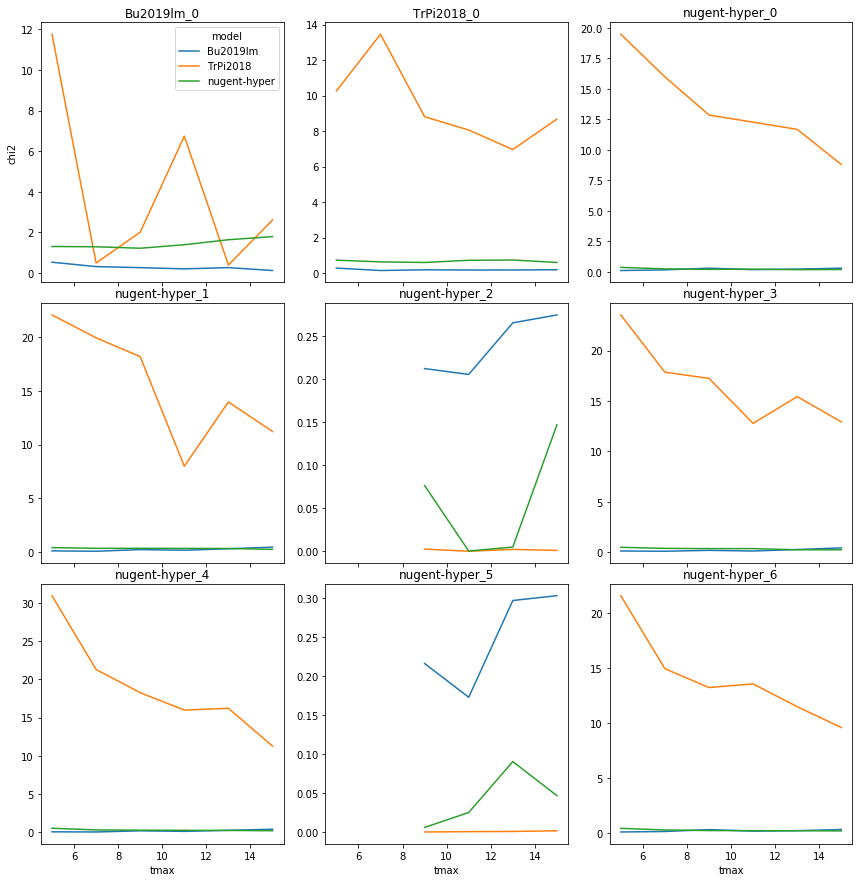

In [25]:
fig, axs = plt.subplots(3, 3, figsize=(12, 12), sharex=True, facecolor='w', edgecolor='k')
fig.tight_layout()
axs = axs.flatten()

objects = df['candidate'].unique()

for idx, obj in enumerate(objects):
    obj_df = df[df['candidate'] == obj]
    obj_df = obj_df.sort_values(by=['model','tmax'])
    sns.lineplot(x='tmax', y=obj_df['chi2'], hue='model', data=obj_df, ax=axs[idx])
    # axs[idx].plot(obj_df['tmax'], obj_df['residuals'], 'o')
    axs[idx].set_title(obj)
    axs[idx].set_xlabel('tmax')
    #axs[idx].set_ylabel('residuals')
    if idx != 0:
        axs[idx].legend().set_visible(False)
        axs[idx].set_ylabel('')
    # axs[idx].set_yscale('log')
    #axs[idx].invert_yaxis()
plt.show()

In [26]:
df.sort_values(by=['chi2'], ascending=True).head(10)

,candidate,model,tmax,log_likelihood,log_evidence,log_evidence_err,log_bayes_factor,luminosity_distance,KNphi,inclination_EM,...,log10_E0,thetaCore,thetaWing,ksiN,L0,dL,b,q,ts,supernova_mag_boost
157,nugent-hyper_5,TrPi2018,9.0,-1.888980,-5.976364,0.052330,-5.976364,131.561191,NaN,0.195835,...,53.0,0.05,0.1,1.0,0.0,3.090000e+19,6.0,0.0,0.0,NaN
95,nugent-hyper_2,TrPi2018,11.0,-2.829995,-8.090283,0.059760,-8.090283,130.081218,NaN,0.192056,...,53.0,0.05,0.1,1.0,0.0,3.090000e+19,6.0,0.0,0.0,NaN
102,nugent-hyper_2,nugent-hyper,11.0,-3.040794,-5.251023,0.038207,-5.251023,243.209599,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.369410
158,nugent-hyper_5,TrPi2018,11.0,-2.821203,-7.776110,0.058383,-7.776110,175.979891,NaN,0.193364,...,53.0,0.05,0.1,1.0,0.0,3.090000e+19,6.0,0.0,0.0,NaN
159,nugent-hyper_5,TrPi2018,13.0,-3.762159,-9.339189,0.062737,-9.339189,155.226572,NaN,0.193421,...,53.0,0.05,0.1,1.0,0.0,3.090000e+19,6.0,0.0,0.0,NaN
97,nugent-hyper_2,TrPi2018,15.0,-4.683186,-11.029163,0.067114,-11.029163,142.431067,NaN,0.193705,...,53.0,0.05,0.1,1.0,0.0,3.090000e+19,6.0,0.0,0.0,NaN
160,nugent-hyper_5,TrPi2018,15.0,-4.699390,-10.718444,0.065652,-10.718444,130.907620,NaN,0.194893,...,53.0,0.05,0.1,1.0,0.0,3.090000e+19,6.0,0.0,0.0,NaN
96,nugent-hyper_2,TrPi2018,13.0,-3.778213,-9.645498,0.063996,-9.645498,111.888541,NaN,0.195367,...,53.0,0.05,0.1,1.0,0.0,3.090000e+19,6.0,0.0,0.0,NaN
94,nugent-hyper_2,TrPi2018,9.0,-1.923276,-6.447787,0.054392,-6.447787,104.327466,NaN,0.194199,...,53.0,0.05,0.1,1.0,0.0,3.090000e+19,6.0,0.0,0.0,NaN
103,nugent-hyper_2,nugent-hyper,13.0,-3.960981,-6.358968,0.039952,-6.358968,312.393175,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.567202


In [27]:
def plot_lc(json_path, remove_nondetections=True, verbose=False, ax=None, **kwargs):
    bf_json = read_json(json_path)
    labels = get_labels(bf_json)
    model = labels['model']
    print(labels) if verbose else None
    dataPath = './injection_sample/lc_{}.dat'.format(labels['candidate'])
    lc_data = get_lc(dataPath)
    sample_times = lc_data['t'].to_numpy()
    if sample_times[0] == 0:
        sample_times[0] = 1e-2
    
    
    lc_fit, lc_fit_labels = gen_lc(bf_json, modelDict(sample_times)[model], sample_times)
    print(modelDict(lc_data['t'])[model]) if verbose else None
    
    bp_dict = get_best_params(bf_json)
    print(bp_dict) if verbose else None
    if ax is None:
        fig, ax = plt.subplots(1, 1, figsize=(8, 8), facecolor='w', edgecolor='k')
    #lc_data = lc_data[lc_data['filter'].isin]
    lc_data[lc_data['mag_unc'] != np.inf].plot(x='t', y='mag', yerr='mag_unc', ax=ax, marker='o', linestyle='None',c='g', label='data', s=50, zorder=100, kind='scatter')
    if not remove_nondetections:
        lc_data[lc_data['mag_unc'] == np.inf].plot(x='t', y='mag', ax=ax, marker='v',c='g', linestyle='None', s=50, zorder=100, kind='scatter')
    
    fit_label = '{} (tmax={:.0f})'.format(model, labels['tmax'])
    ax.scatter(sample_times, lc_fit['g'], label=fit_label, **kwargs)
    ax.title.set_text(labels['candidate'])
    ax.legend()
    return lc_data, lc_fit

{'candidate': 'nugent-hyper_3', 'model': 'nugent-hyper', 'tmax': 15.0}
SupernovaLightCurveModel(model={self.model})
({'luminosity_distance': 271.36643796037526, 'KNtimeshift': -0.3022328756776336, 'supernova_mag_boost': -4.579886658939997, 'Ebv': 0.04945372425421744, 'log_likelihood': -6.434433654390908, 'log_prior': -7.6565926841399765}, {'log_likelihood': -6.434433654390908, 'log_evidence': -9.53498299140878, 'log_evidence_err': 0.04952431611863565, 'log_bayes_factor': -9.53498299140878})


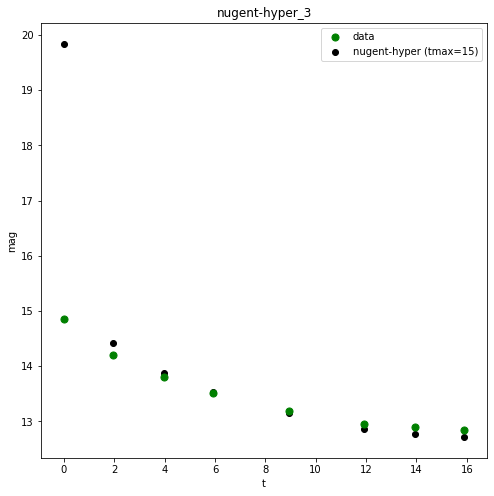

In [28]:
data, fit = plot_lc('fits/nugent-hyper_3_fit_nugent-hyper/nugent-hyper_3_fit_nugent-hyper_t_15_result.json', remove_nondetections=True, verbose=True,c='k')

{'candidate': 'nugent-hyper_5', 'model': 'nugent-hyper', 'tmax': 3.0}
SupernovaLightCurveModel(model={self.model})
({'luminosity_distance': 289.47410242864476, 'KNtimeshift': 0.7835371697580711, 'supernova_mag_boost': 4.8119972651919145, 'Ebv': 0.5575836250577777, 'log_likelihood': -4.2732742689412954e-08, 'log_prior': -11.220338435529989}, {'log_likelihood': -4.2732742689412954e-08, 'log_evidence': -1.109530734243879, 'log_evidence_err': 0.02929713610423564, 'log_bayes_factor': -1.109530734243879})


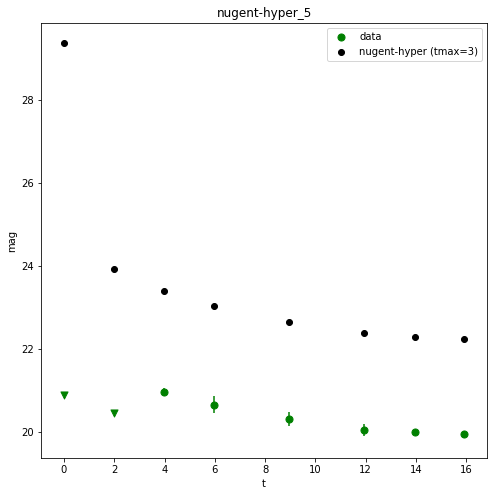

In [29]:
best_chi2 = df.sort_values(by=['chi2'], ascending=True).reset_index(drop=True).loc[8]
# display(best_chi2)
best_json = 'fits/nugent-hyper_5_fit_nugent-hyper/nugent-hyper_5_fit_nugent-hyper_t_3_result.json'
data, fit = plot_lc(best_json, verbose=True, remove_nondetections=False, c='k')

In [38]:
json_list = sorted(glob.glob('fits/TrPi2018_0_fit_TrPi2018/TrPi2018_0_fit_TrPi2018_t_*_result.json'), key=LooseVersion)
json_list

['fits/TrPi2018_0_fit_TrPi2018/TrPi2018_0_fit_TrPi2018_t_3_result.json',
 'fits/TrPi2018_0_fit_TrPi2018/TrPi2018_0_fit_TrPi2018_t_5_result.json',
 'fits/TrPi2018_0_fit_TrPi2018/TrPi2018_0_fit_TrPi2018_t_7_result.json',
 'fits/TrPi2018_0_fit_TrPi2018/TrPi2018_0_fit_TrPi2018_t_9_result.json',
 'fits/TrPi2018_0_fit_TrPi2018/TrPi2018_0_fit_TrPi2018_t_11_result.json',
 'fits/TrPi2018_0_fit_TrPi2018/TrPi2018_0_fit_TrPi2018_t_13_result.json',
 'fits/TrPi2018_0_fit_TrPi2018/TrPi2018_0_fit_TrPi2018_t_15_result.json']

{'candidate': 'TrPi2018_0', 'model': 'TrPi2018', 'tmax': 3.0}
GRBLightCurveModel(model=TrPi2018)
({'luminosity_distance': 132.97390710169685, 'KNtimeshift': 0.07019013819342579, 'inclination_EM': 0.17911541928788252, 'log10_n0': -0.7434014930889887, 'p': 2.7303878500863896, 'log10_epsilon_e': -0.5956805577194371, 'log10_epsilon_B': -1.4210591116777866, 'Ebv': 0.10229131824129656, 'log10_E0': 53.0, 'thetaCore': 0.05, 'thetaWing': 0.1, 'ksiN': 1.0, 'L0': 0.0, 'dL': 3.09e+19, 'b': 6.0, 'q': 0.0, 'ts': 0.0, 'log_likelihood': -1.8381682308202167, 'log_prior': -11.056801097738314}, {'log_likelihood': -1.8381682308202167, 'log_evidence': -4.777041975505812, 'log_evidence_err': 0.04619971157689995, 'log_bayes_factor': -4.777041975505812})


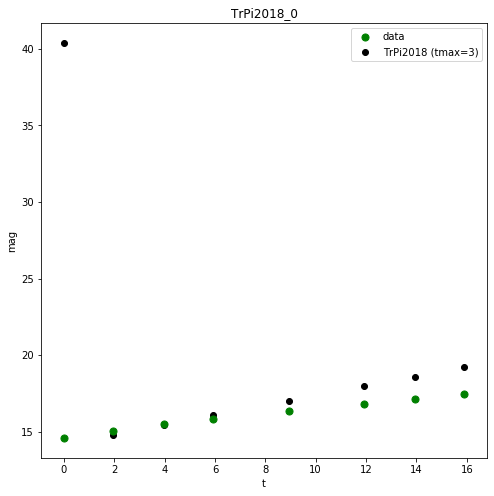

In [39]:
data, fit = plot_lc(json_list[0], verbose=True, remove_nondetections=False, c='k')

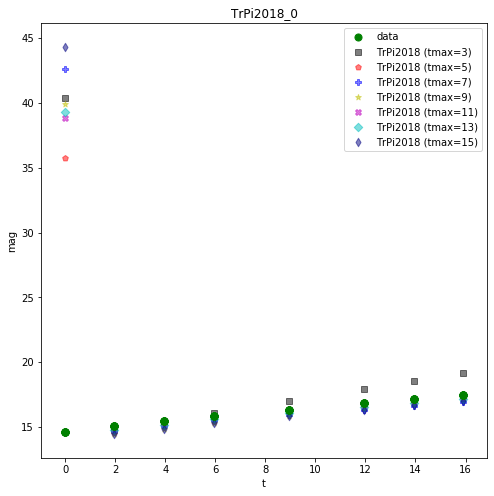

In [40]:
colors = ['k', 'r', 'b',  'y', 'm', 'c', 'navy']
markers = [ 's', 'p', 'P', '*', 'X', 'D', 'd']
fig, ax = plt.subplots(1, 1, figsize=(8, 8), facecolor='w', edgecolor='k')
for idx, json_idx in enumerate(json_list):
    data, fit = plot_lc(json_idx, verbose=False, remove_nondetections=False, ax=ax,  c=colors[idx], alpha=0.5, marker=markers[idx])
handles, labels = plt.gca().get_legend_handles_labels()
by_label = dict(zip(labels, handles))
plt.legend(by_label.values(), by_label.keys())